# Import

In [1]:
import pandas as pd 
import glob
import cv2 as cv
import random
import os
from fisheye import ApplyFishEye

import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.metrics import f1_score, accuracy_score

from tqdm.auto import tqdm
import timm
import math
from sklearn.model_selection import train_test_split

import segmentation_models_pytorch as smp
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Utils

In [2]:
# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = 'a'
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':30, # 추가 학습할때는 10 Epoch, 3e-5로 가자
    'LEARNING_RATE':3e-5,
    'BATCH_SIZE':8,
    'SEED':41
}

seed_everything(CFG['SEED']) # Seed 고정

In [3]:
#폴더 이동시 경로 수정이 필요할 수 있음 
train_source = glob.glob("../Data/train_source_image/*")
val_source = glob.glob("../Data/val_source_image/*")
train_gt = glob.glob("../Data/train_source_gt/*")
val_gt = glob.glob("../Data/val_source_gt/*")

train_source += val_source
train_gt += val_gt

# glob 이후에 정렬이 안되어 있기 때문에, source - gt matching을 위해 정렬
train_source.sort()
train_gt.sort()

print(train_source)

['../Data/train_source_image\\TRAIN_SOURCE_0000.png', '../Data/train_source_image\\TRAIN_SOURCE_0001.png', '../Data/train_source_image\\TRAIN_SOURCE_0002.png', '../Data/train_source_image\\TRAIN_SOURCE_0003.png', '../Data/train_source_image\\TRAIN_SOURCE_0004.png', '../Data/train_source_image\\TRAIN_SOURCE_0005.png', '../Data/train_source_image\\TRAIN_SOURCE_0006.png', '../Data/train_source_image\\TRAIN_SOURCE_0007.png', '../Data/train_source_image\\TRAIN_SOURCE_0008.png', '../Data/train_source_image\\TRAIN_SOURCE_0009.png', '../Data/train_source_image\\TRAIN_SOURCE_0010.png', '../Data/train_source_image\\TRAIN_SOURCE_0011.png', '../Data/train_source_image\\TRAIN_SOURCE_0012.png', '../Data/train_source_image\\TRAIN_SOURCE_0013.png', '../Data/train_source_image\\TRAIN_SOURCE_0014.png', '../Data/train_source_image\\TRAIN_SOURCE_0015.png', '../Data/train_source_image\\TRAIN_SOURCE_0016.png', '../Data/train_source_image\\TRAIN_SOURCE_0017.png', '../Data/train_source_image\\TRAIN_SOURCE_001

In [4]:
# DF 생성 
df = pd.DataFrame(columns=['source','gt'])
df['source'] = train_source
df['gt'] = train_gt
df

,source,gt
0,../Data/train_source_image\TRAIN_SOURCE_0000.png,../Data/train_source_gt\TRAIN_SOURCE_0000.png
1,../Data/train_source_image\TRAIN_SOURCE_0001.png,../Data/train_source_gt\TRAIN_SOURCE_0001.png
2,../Data/train_source_image\TRAIN_SOURCE_0002.png,../Data/train_source_gt\TRAIN_SOURCE_0002.png
3,../Data/train_source_image\TRAIN_SOURCE_0003.png,../Data/train_source_gt\TRAIN_SOURCE_0003.png
4,../Data/train_source_image\TRAIN_SOURCE_0004.png,../Data/train_source_gt\TRAIN_SOURCE_0004.png
...,...,...
2655,../Data/val_source_image\VALID_SOURCE_461.png,../Data/val_source_gt\VALID_SOURCE_461.png
2656,../Data/val_source_image\VALID_SOURCE_462.png,../Data/val_source_gt\VALID_SOURCE_462.png
2657,../Data/val_source_image\VALID_SOURCE_463.png,../Data/val_source_gt\VALID_SOURCE_463.png
2658,../Data/val_source_image\VALID_SOURCE_464.png,../Data/val_source_gt\VALID_SOURCE_464.png


In [5]:
mask_back = np.load("../DataPreprocessing/mask0_1024_512.npy")
img_back = cv.imread('../DataPreprocessing/back.png')

mask_front = np.load("../DataPreprocessing/mask1_1024_512.npy")
img_front = cv.imread('../DataPreprocessing/front.png')


# Custom Dataset

In [6]:
import matplotlib.pyplot as plt
class CustomDataset(Dataset): 
    def __init__(self, source, gt, transform=None,t2= None, infer=False, is_dof=False):
        self.source = source
        self.gt = gt
        self.transform = transform
        self.t2 = t2
        self.infer = infer


    def __getitem__(self, idx):
        img_path = self.source[idx]
        mask_path = self.gt[idx]
        image = cv.imread(img_path)
        mask = cv.imread(mask_path)
        
        mask[mask == 255] = 12 #/ 배경을 픽셀값 12로 간주 이거 원래 없던 값!
        mask[mask == 0] = 13 # 잠시 0값을 다른 값으로 변경 
        
        if self.transform: # 여기서 Data Aug를 진행해주고  
            augmented = self.transform(image=image, mask = mask) 
            image = augmented['image']
            mask = augmented['mask']
        
        if self.is_dof:
            
            if idx % 2 == 0:
                image = ApplyFishEye(image, mask_np = mask_back, mask_image=img_back, is_target= False)
                mask = ApplyFishEye(mask, mask_np = mask_back, mask_image=img_back, is_target= True)
            else :
                image = ApplyFishEye(image, mask_np = mask_front, mask_image=img_front, is_target= False)
                mask = ApplyFishEye(mask, mask_np = mask_front, mask_image=img_front, is_target= True)
        else:
            if idx % 2 == 0:
                image = ApplyFishEye(image, mask_np = mask_back, mask_image=img_back, is_target= False)
                mask = ApplyFishEye(mask, mask_np = mask_back, mask_image=img_back, is_target= True)
            else :
                image = ApplyFishEye(image, mask_np = mask_front, mask_image=img_front, is_target= False)
                mask = ApplyFishEye(mask, mask_np = mask_front, mask_image=img_front, is_target= True)
            
        mask[mask == 0] = 12
        mask[mask == 13] = 0   
        
        #추론의 경우 이때 self.gt[idx] 은 0,1 의 index
        if self.infer:
            image = cv.imread(img_path)
            label = self.gt[idx]
            if self.transform:
                image = self.transform(image=image)['image']
            return image, label
        
        

            
        if self.t2: #현재 들어가는 구조가 다름 totensor 진행해줌
            augmented = self.t2(image=image, mask = mask) 
            mask = augmented['mask']
        
        fig, axs = plt.subplots(1, 2, figsize=(16, 8))
        axs[0].imshow(image)
        axs[0].set_title('Image 1')
        axs[1].imshow(mask)
        axs[1].set_title('Image 2')
        plt.show()
        
        return image, mask
    
    def __len__(self):
        return len(self.source)
    

# Transfrom - Data Augmentation

In [7]:
transform = A.Compose(
    [   
        A.Resize(512, 1024),
        # A.Normalize(),
        # ToTensorV2()
    ]
)

transform_basic = A.Compose(
    [   
        A.RandomCrop(480*2,960*2),
        # A.Normalize(),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        A.Resize(512, 1024),
    ]
)

transform_basic_DOF = A.Compose(
    [   
        A.RandomCrop(480*2,960*2),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        A.Rotate(limit=15 ,p=1, border_mode=cv.BORDER_REPLICATE),
        A.Resize(512, 1024),
    ]
)



transform_gt = A.Compose(
    [   
        A.Resize(128, 256), # 반대일 수도 있음 
        A.Normalize(),
        ToTensorV2()
    ]
)


# Data Loader

In [8]:
train, val, _, _ = train_test_split(df, _, test_size=0.05, random_state=CFG['SEED'])

In [9]:
train_dataset1= CustomDataset(source = train['source'].values, gt = train['gt'].values, transform=transform,t2 = transform_gt, infer=False, is_dof=False)
train_dataset2 = CustomDataset(source = train['source'].values, gt = train['gt'].values, transform=transform_basic,t2 = transform_gt, infer=False, is_dof=False)
train_dataset3 = CustomDataset(source = train['source'].values, gt = train['gt'].values, transform=transform_basic,t2 = transform_gt, infer=False, is_dof=True)


train_loader = DataLoader(train_dataset2 + train_dataset2 + train_dataset3, batch_size=4, shuffle=True, num_workers=0)

val_dataset = CustomDataset(source = val['source'].values, gt = val['gt'].values, transform=None,t2 = transform_gt, infer=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=0)

# Model

Segformer

In [10]:
import torch
import torch.nn as nn
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation, SegformerConfig



# Segformer 모델을 불러오고 구성을 수정합니다.
config = SegformerConfig.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-512-1024")
# config.num_labels = 13  # 분할 클래스 수에 맞게 수정
config.num_labels = 19 


feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-512-1024", size = {"height": 512,"width": 1024})
segformer_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-512-1024", config=config, ignore_mismatched_sizes=True)

# 분할 모델을 만듭니다.
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.backbone1 =feature_extractor
        self.backbone2 = segformer_model
        self.last_conv1 = nn.Conv2d(in_channels=config.num_labels, out_channels=13, kernel_size=1, padding=0)
        
    def forward(self, x):
        x = self.backbone1(images=x, return_tensors="pt").to(device)
        x = self.backbone2(**x).logits
        x = self.last_conv1(x) # 위랑 연결 
        
        return x

model = SegmentationModel() 


c:\Users\EHmin\anaconda3\envs\EHmin\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
c:\Users\EHmin\anaconda3\envs\EHmin\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


# 추가적으로 distort된 것에 대한 증강을 하기 위해 사용한거임! 돌릴때 주의 

In [11]:
# model.load_state_dict(torch.load('./models/Segformer_pretrained_decoder.pt'))
print(model)

SegmentationModel(
  (backbone2): SegformerForSemanticSegmentation(
    (segformer): SegformerModel(
      (encoder): SegformerEncoder(
        (patch_embeddings): ModuleList(
          (0): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
            (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          )
          (1): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          )
          (2): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
          )
          (3): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            

In [12]:
for param in model.parameters(): # encoder는 잠그고 학습 
    param.requires_grad = False
    
for param in model.backbone2.parameters():
    param.requires_grad = True

for param in model.last_conv1.parameters():
    param.requires_grad = True

# Validation

In [13]:
# define mIoU for Score >> 가져온 함수여서... batch 사이즈에 대한 고려가 안되어 있을 수 있음
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=13):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
                
    return np.nanmean(iou_per_class) , iou_per_class

In [14]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0
    val_score = 0
    Check_list = []
    with torch.no_grad():
        for source , gt in tqdm(iter(val_loader)):
            # inputs = feature_extractor(images=source, return_tensors="pt")
            # inputs = inputs.to(device)
            inputs = source
            gt = gt.long().to(device)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, gt.squeeze(1))
            val_loss += loss.item()
            a, b = mIoU(outputs, gt)
            val_score += a
            Check_list.append(b)
    Check_list = np.array(Check_list)
    print(np.nanmean(Check_list, axis=0))
    return val_loss/len(val_loader) , val_score/len(val_loader)
    

# Train

In [15]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    # Model load 
    model = model.to(device) # 그냥 model.to(device)만 하면 저장 안됨
    criterion = torch.nn.CrossEntropyLoss()
    
    best_score = 0
    best_model = None

    for epoch in range(0, CFG['EPOCHS']):
        model.train()
        train_loss = 0
        
        for source , gt in tqdm(train_loader):
            # source = cv.cvtColor(source, cv.COLOR_RGB2BGR)
            inputs = source
            # inputs = feature_extractor(images=source, return_tensors="pt")
            # inputs = inputs.to(device)
            gt = gt.long().to(device)
            
            
            optimizer.zero_grad() #! 이건 뭐해주는거지?? 추후에 확인 필
            outputs = model(inputs)
            
            loss = criterion(outputs, gt.squeeze(1))
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        _train_loss = train_loss/len(train_loader)
    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val accuracy score : [{_val_score:.5f}]')
         
        if scheduler is not None:
            scheduler.step(_val_score)
        
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
            torch.save(best_model.state_dict(), "./models/Segformer_pretrained_with_noMask.pt")
    
    return best_model

  0%|          | 0/1264 [00:00<?, ?it/s]

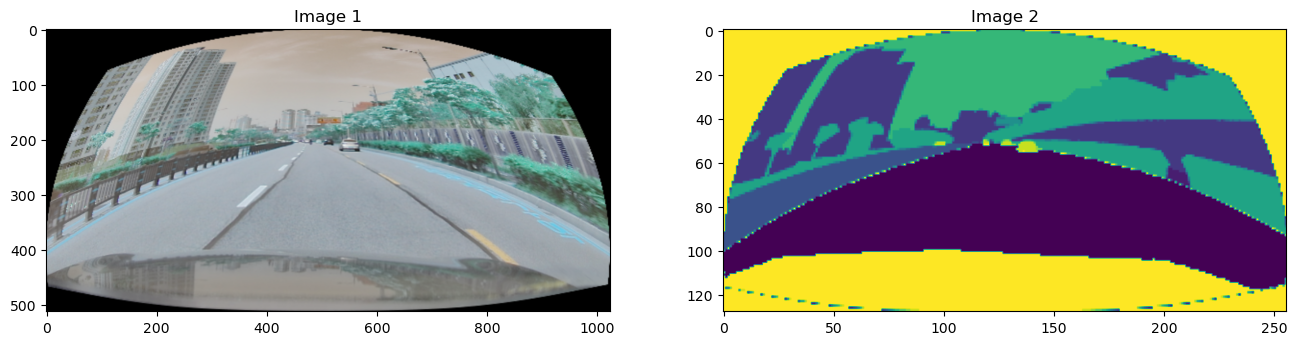

1
[[[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  ...
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]]

 [[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  ...
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]]

 [[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  ...
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]]

 ...

 [[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  ...
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]]

 [[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444

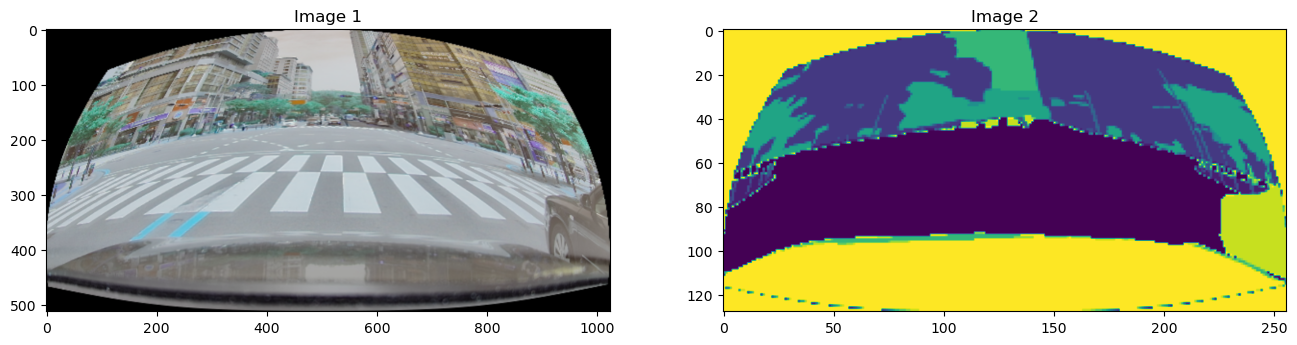

4
[[[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  ...
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]]

 [[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  ...
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]]

 [[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  ...
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]]

 ...

 [[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  ...
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]]

 [[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444

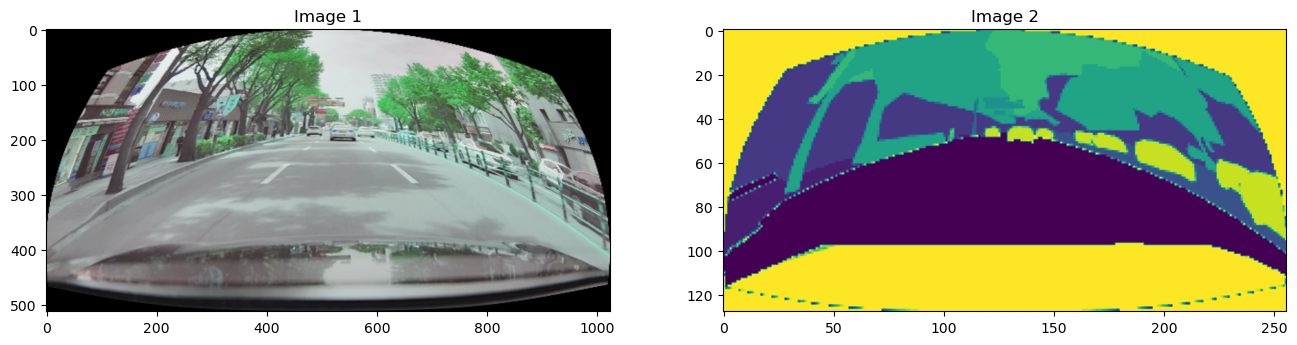

2
[[[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  ...
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]]

 [[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  ...
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]]

 [[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  ...
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]]

 ...

 [[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  ...
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]]

 [[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444

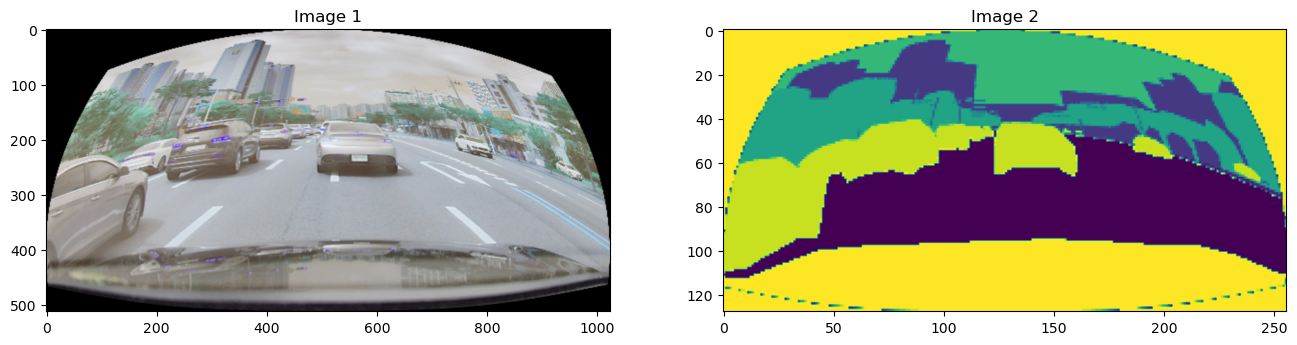

2
[[[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  ...
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]]

 [[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  ...
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]]

 [[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  ...
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]]

 ...

 [[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  ...
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444]]

 [[-2.117904  -2.0357141 -1.8044444]
  [-2.117904  -2.0357141 -1.8044444

ValueError: The image to be converted to a PIL image contains values outside the range [0, 1], got [-2.1179039478302, 2.361132860183716] which cannot be converted to uint8.

In [16]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

# EVAL

In [ ]:
df_test = pd.read_csv('../DataPreprocessing/front_OR_back.csv')
df_test

In [ ]:
test_dataset = CustomDataset(source = df_test['source'].values ,gt = df_test['label'].values , transform=None,t2=None, infer=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0 )

In [ ]:
mask_0 = np.load("../DataPreprocessing/mask0.npy")
mask_1 = np.load("../DataPreprocessing/mask1.npy")

In [ ]:
with torch.no_grad():
    # infer_model.eval()
    model = model.to(device)
    result = []
    for images, label in tqdm(test_loader):
        inputs = images
        outputs = model(inputs)
        
        outputs = nn.functional.interpolate(outputs,size=(540,960), mode='bilinear',align_corners=False)
        outputs = outputs.argmax( dim=1).to("cpu").numpy()
        
        flag = True
        for pred , l in zip(outputs,label):
            new_pred = np.array(pred)
            new_pred = new_pred.astype(np.uint8)
            # print(new_pred.shape)
            
            if l == 0:
                new_pred[~mask_0] = 12
            else:
                new_pred[~mask_1] = 12
             
            if flag:   
                np.save('./test_img.npy', new_pred)
                flag = False
                
            for class_id in range(12):
                class_mask = (new_pred == class_id).astype(np.uint8)
                if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
                    mask_rle = rle_encode(class_mask)
                    result.append(mask_rle)
                else: # 마스크가 존재하지 않는 경우 -1
                    result.append(-1)

# Submisssion

In [ ]:
submit = pd.read_csv('../Data/sample_submission.csv')
submit['mask_rle'] = result
submit

In [ ]:
submit.to_csv('./Segformer_fintunning_with_noMask.csv', index=False)